# Gesture Recognition
Conv 3D model

In [1]:
import numpy as np
import os
from scipy.misc import imread
import datetime
from skimage.transform import resize 
from skimage import io
import glob
import matplotlib.pyplot as plt


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


## Setting up the paths for reading data

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())


train_path = 'Project_data/train'
val_path = 'Project_data/val'


### Parameters Initialization

We'll normalize and bring all the images to a uniform size before feeding into the model. Initializing the variables accordingly

In [4]:
frames_per_video = 15 #number of images to be fed per video(folder in train data) 

img_rows = 120  
img_cols = 120 
img_channels = 3 #RGB Channels

num_classes = 5 #5 hand gestures correspond to 5 classes
batch_size = 10

## Utility functions
 
 
 1. normalize_image: used to normalize each channel of each image seprately
 2. crop_and_resize_image: used to crop image and resize it to 120 X 120 dimensions
 3. plot_image: used to plot multiple images side by side. 
 4. print_image_with_metadata: prints image with shape and intensity ranges
 

In [6]:
def normalize_image(image):
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    return image


In [7]:
def crop_and_resize_image(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = resize(img, (img_rows,img_cols))
    return resized_image


In [8]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [9]:
def print_image_with_metadata(image):
    print("image shape is: {}".format(image.shape))
    print("image min: "+str(image.min())+"  image max: "+str(image.max()))
    plt.imshow(image);

## Understanding data

#### Sample One
Fetching a random 360 by 360 frame from a training video as sample

image shape is: (360, 360, 3)
image min: 0  image max: 255


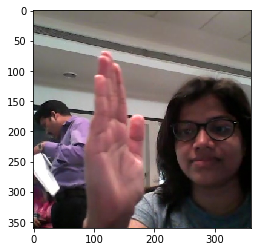

In [10]:
# Sample Video One: WIN_20180907_15_35_09_Pro_Right 

video_path_one = os.path.join(train_path,"WIN_20180907_15_35_09_Pro_Right Swipe_new" , '*')
video_path_contents_one = glob.glob(video_path_one)

# access 10th frame(image) from the video
sample_image_one = io.imread(video_path_contents_one[10])
print_image_with_metadata(sample_image_one)

#### Sample Two
Fetching a random 160 by 120 frame from a training video as sample

image shape is: (120, 160, 3)
image min: 0  image max: 255


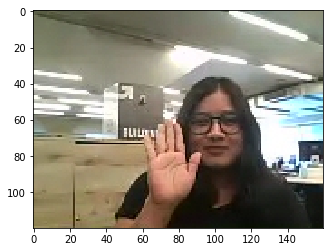

In [11]:
# Sample Video: WIN_20180925_17_31_48_Pro_Stop_new

video_path_two = os.path.join(train_path,"WIN_20180925_17_31_48_Pro_Stop_new" , '*')
video_path_contents_two = glob.glob(video_path_two)

# access some element (a file) from the list
sample_image_two = io.imread(video_path_contents_two[10])
print_image_with_metadata(sample_image_two)

### Bringing down both the images to the same scale by transforming them

Cropping and resizing

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image shape is: (120, 120, 3)
image min: 0.0  image max: 1.0


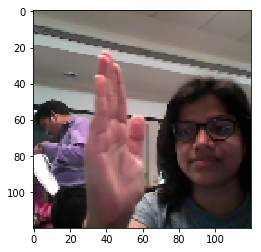

In [12]:
# Let's try and bring both the images to an aribtrary scale of (img_rows,img_cols,img_channels)
sample_image_one_cropped = crop_and_resize_image(sample_image_one)
print_image_with_metadata(sample_image_one_cropped)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image shape is: (120, 120, 3)
image min: 0.0  image max: 1.0


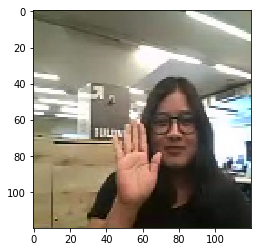

In [13]:
# sample_image_two with size 160 by 120 needs to be cropped before resizing. 
#Custom cropping dimensions(found by trial and error) are defined in function crop_and_resize_image

sample_image_two_cropped = crop_and_resize_image(sample_image_two)
print_image_with_metadata(sample_image_two_cropped)

### Both the images are now of the dimensions (img_rows x img_cols x img_channels) and still capturing the gesture

## Checking class imbalance if any

In [14]:
category_list = [int(item.split(";")[-1].strip('\n')) for item in train_doc]
for i in range(num_classes):
    print("category {} count is: {}".format(i,category_list.count(i)))
    

category 0 count is: 136
category 1 count is: 137
category 2 count is: 130
category 3 count is: 137
category 4 count is: 123


### So we see all classes have equal distribution. Hence no data imbalance

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

### There are two functions created
1. get_batch_data: returns data for a given batch with labels
2. generator: this function used to get data in batch without augmentation


In [15]:
def get_batch_data(source_path, current_batch_size, full_batch_size, t, batch, img_idx):
          
          # current_batch_size != full_batch_size, in case of partial batches
          # current_batch_size = full_batch_size, in case of full batches
            
          # initialize batch_data
            x, y, z, channels = len(img_idx), img_rows, img_cols, img_channels  
            batch_data = np.zeros((current_batch_size,x,y,z,channels)) # batch_data has a place holder for all sequences(videos) in a batch 
            
            # initilaize batch_labels
            batch_labels = np.zeros((current_batch_size,5)) # batch_labels is the one hot representation of the output
            
            # iterate over folders in a batch
            for folder in range(current_batch_size):  # Each folder represents one video
                
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*full_batch_size)].split(';')[0])
                
                # iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx): 
                    image = io.imread(source_path+'/'+ t[folder + (batch*full_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    resized_image = crop_and_resize_image(image)
                    
                    # normalize images(per channel)
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])
                                       
                batch_labels[folder, int(t[folder + (batch*full_batch_size)].strip().split(';')[2])] = 1
            #print("batch_data_updated............{}".format(batch_data))
            #print("batch_labels_updated..............{}".format(batch))
            return batch_data, batch_labels

In [16]:
def generator(source_path, folder_list, batch_size, ablation=False, validation = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30,2)]
    
    while True:
        t = np.random.permutation(folder_list)
        num_folders = len(t)
        
        # number of full batches
        num_batches = int(np.floor(num_folders/batch_size))
        
        # derive partial batch size(if any)
        partial_batch_size = 0
        num_folders_in_full_batch = batch_size*num_batches
        
        if (num_folders != num_folders_in_full_batch):
            partial_batch_size = num_folders - num_folders_in_full_batch
        
        # generate data from full batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = get_batch_data(source_path, batch_size, batch_size, t, batch, img_idx)
            yield batch_data, batch_labels
                            
        # generate data from partial batches
        if (partial_batch_size > 0):
            partial_batch_number =  batch + 1
            partial_batch_data, partial_batch_labels =  get_batch_data(source_path, partial_batch_size, batch_size, t, partial_batch_number, img_idx)
            yield partial_batch_data, partial_batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
# Declaring parameters to be used in model building   

curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2


# Input
input_shape=(frames_per_video,img_rows,img_cols,img_channels)

# FeatureMap and Dense List
featuremap_list = [16,32,64]
dense_list = [128,64,5]

# Model
model = Sequential()

#Conv3D layers
#-----------------------------------------------------------

#Conv3D layer 1
model.add(Conv3D(featuremap_list[0], kernel_size=(3,3,3),input_shape=input_shape,padding='same'))
model.add(Activation('relu'))

#Conv3D layer 2
model.add(Conv3D(featuremap_list[1], kernel_size=(3,3,3),padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))
#-----------------------------------------------------------

#Conv3D layer 3
model.add(Conv3D(featuremap_list[2], kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#-----------------------------------------------------------
#BatchNormalization and Dropouts
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#-----------------------------------------------------------
#Flatten Layers
model.add(Flatten())

model.add(Dense(dense_list[0], kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(dense_list[1], activation='relu'))

#-----------------------------------------------------------
#Softmax layer
model.add(Dense(dense_list[2], activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [19]:
optimiser = 'sgd'#Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 120, 120, 32)  13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 60, 60, 64)     18496     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 60, 60, 64)     0         
__________

### Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
train_generator = generator(train_path, train_doc, batch_size)

val_generator = generator(train_path, train_doc, batch_size)

### Model naming and callbacks

In [21]:
model_name = 'init_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Train Model

In [23]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, use_multiprocessing=True,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 10
Source path =  Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("An

Epoch 1/25
67/67 [==============================] - 179s 3s/step - loss: 4.1673 - categorical_accuracy: 0.2453 - val_loss: 3.9886 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to init__2019-06-2411_45_08.927617/model-00001-4.17208-0.24434-3.98856-0.26000.h5
Epoch 2/25
67/67 [==============================] - 82s 1s/step - loss: 3.9168 - categorical_accuracy: 0.3374 - val_loss: 3.7175 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to init__2019-06-2411_45_08.927617/model-00002-3.91732-0.34087-3.71748-0.42000.h5
Epoch 3/25
67/67 [==============================] - 84s 1s/step - loss: 3.8001 - categorical_accuracy: 0.3711 - val_loss: 4.0377 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to init__2019-06-2411_45_08.927617/model-00003-3.80433-0.36802-4.03767-0.24000.h5
Epoch 4/25
67/67 [==============================] - 87s 1s/step - loss: 3.6628 - categorical_accuracy: 0.3901 - val_loss: 4.6830 - val_categorical_accuracy: 0.2600

Epoch 00004: sa